<a href="https://colab.research.google.com/github/Itai1991Ortner/Google-Play/blob/main/class_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

the purpose of this project is to create classification models which can learn the job descriptions and predict wich job offer are fraud

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split as split ,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
my_path='/content/drive/MyDrive/Classification Project/fake_job_postings.csv'
df=pd.read_csv(my_path).set_index('job_id')

# Data cleaning

In [ ]:
# create a map of features - to understand the content better
def table_info(df):
    print(f"Dataset Shape: {df.shape}")
    first_check = pd.DataFrame(df.dtypes,columns=['dtypes'])
    first_check = first_check.reset_index()
    first_check['Name'] = first_check['index']
    first_check = first_check[['Name','dtypes']]
    first_check['isnull'] = df.isnull().sum().values    
    first_check['num_Uniques'] = df.nunique().values

    return first_check

In [ ]:
#present the table above
table_info(df)

Dataset Shape: (17880, 17)


,Name,dtypes,isnull,num_Uniques
0,title,object,0,11231
1,location,object,346,3105
2,department,object,11547,1337
3,salary_range,object,15012,874
4,company_profile,object,3308,1709
5,description,object,1,14801
6,requirements,object,2695,11968
7,benefits,object,7210,6205
8,telecommuting,int64,0,2
9,has_company_logo,int64,0,2


In [ ]:
#simple general cleaning
df=df.rename(lambda col: col.strip(),axis=1)
df["function"]=df["function"].fillna("Other")
df["required_education"]=df["required_education"].fillna("Unspecified")
df["department"]=df["department"].fillna("All")
is_fraud=df[df["fraudulent"]==1]
df["employment_type"]=df["employment_type"].fillna('')
df["required_experience"]=df["required_experience"].fillna('')

# EDA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


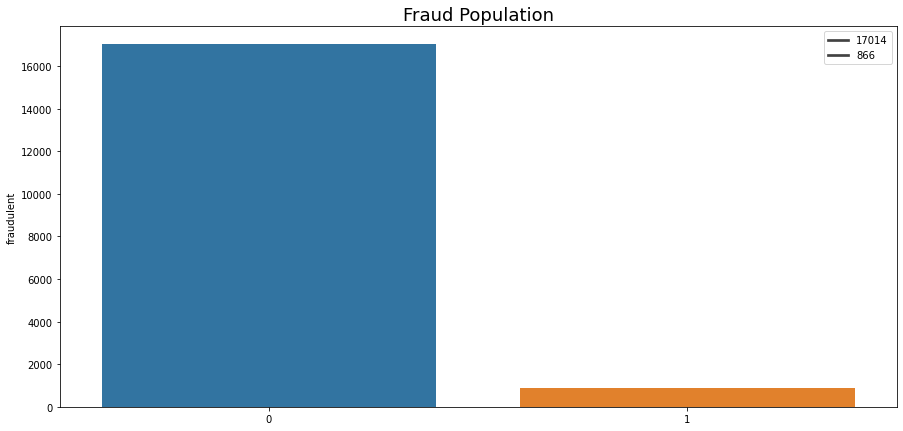

In [ ]:
# graph shows imbalance problem
fraudulent = ['Fake', 'Real']
figure = plt.figure(figsize = (15,7))
fraud_pop = df['fraudulent'].value_counts()
sns.barplot(fraud_pop.index, fraud_pop)
plt.legend(fraud_pop)
plt.title('Fraud Population', size = 18)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


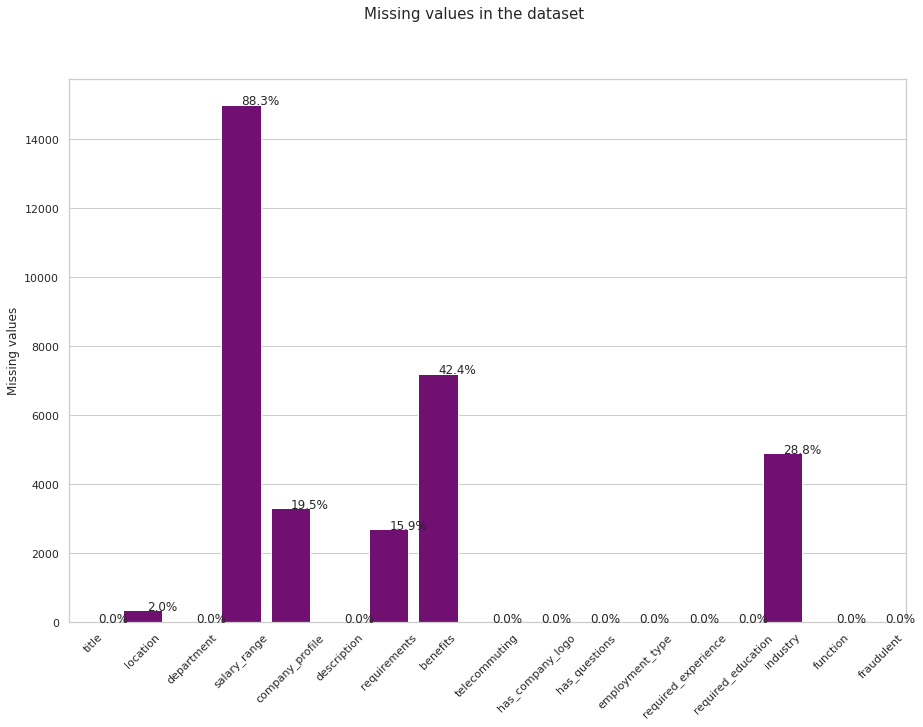

In [ ]:
#again checking nulls
null_values = df.isnull().sum()
sns.set(style="whitegrid")
plt.figure(figsize = (15,10))
total = float(len(null_values))
ax = sns.barplot(null_values.index, null_values, color="Purple")
for p in ax.patches:
    percentage = '{:.1f}%'.format((p.get_height()/total)/10)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.suptitle('Missing values in the dataset', size = 15)
plt.ylabel('Missing values')
plt.xticks(rotation = '45')
plt.show()

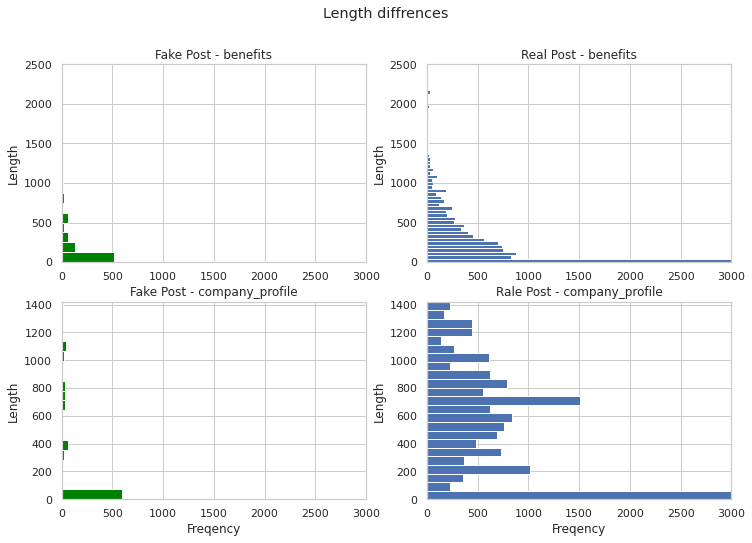

In [ ]:
#showing the diffrences between text length in text fields
char_df = df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
char_df = char_df.fillna('')

fig,ax= plt.subplots(ncols=2,nrows=2, figsize=(12, 8))
num_fake=char_df[char_df["fraudulent"]==1]['benefits'].str.len()
ax[0][0].hist(num_fake,bins = 20,color='green',orientation='horizontal')
ax[0][0].set_xlim(0,3000)
ax[0][0].set_ylabel('Length')
ax[0][0].set_ylim(0,num_fake.max())
ax[0][0].set_title('Fake Post - benefits')
num_true =char_df[char_df["fraudulent"]==0]['benefits'].str.len()
ax[0][1].set_xlim(0,3000)
ax[0][1].set_ylabel('Length')
ax[0][1].set_ylim(0,num_fake.max())
ax[0][1].hist(num_true, bins = 100,orientation='horizontal')
ax[0][1].set_title('Real Post - benefits')
num_fake=char_df[char_df["fraudulent"]==1]['company_profile'].str.len()
ax[1][0].hist(num_fake,bins = 20,color='green',orientation='horizontal')
ax[1][0].set_xlabel('Freqency')
ax[1][0].set_xlim(0,3000)
ax[1][0].set_ylabel('Length')
ax[1][0].set_ylim(0,num_fake.max())
ax[1][0].set_title('Fake Post - company_profile')
num_true =char_df[char_df["fraudulent"]==0]['company_profile'].str.len()
ax[1][1].set_xlabel('Freqency')
ax[1][1].set_xlim(0,3000)
ax[1][1].set_ylabel('Length')
ax[1][1].set_ylim(0,num_fake.max())
ax[1][1].hist(num_true, bins = 100,orientation='horizontal')
ax[1][1].set_title('Rale Post - company_profile')
fig.suptitle('Length diffrences')
plt.show()

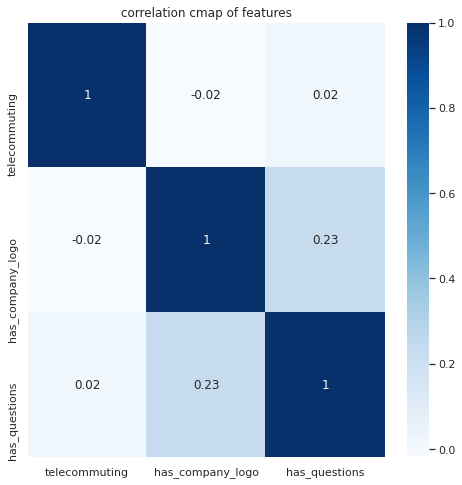

In [ ]:
#correlation heatmap plot
plt.figure(figsize=(8,8))
correl=df.drop(['fraudulent'],axis=1).corr()
sns.heatmap(correl,annot=True,cmap='Blues')
plt.title('correlation cmap of features')
plt.show()

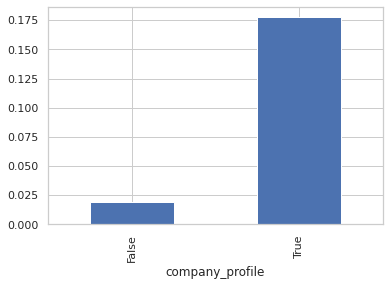

In [ ]:
#nulls ratio in fake jobs posts
df.groupby(df["company_profile"].isna())["fraudulent"].mean().plot.bar()

# Preprocessing

In [ ]:
#creating X and y
X_ohe=df[["telecommuting","has_company_logo","has_questions","employment_type","required_experience","required_education"]]
X_text=df[["title","company_profile","description","requirements","benefits"]]
y=df["fraudulent"]

In [ ]:
 #creating new Features for text length
 X_text["company_profile_len"]=X_text["company_profile"].str.len().fillna(0.0)
 X_text["description_len"]=X_text["description"].str.len().fillna(0.0)
 X_text["requirements_len"]=X_text["requirements"].str.len().fillna(0.0)
 X_text["benefits_len"]=X_text["benefits"].str.len().fillna(0.0)

In [ ]:
X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = split(X_ohe, y, test_size = 0.2, random_state = 3)

In [ ]:
X_text_train, X_text_test, y_text_train, y_text_test = split(X_text, y, test_size = 0.2, random_state = 3)

# One hot encoder

In [ ]:
#one hot encoder for simple data
class MyOneHotEncoder(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        return 
    def fit(self, X, y=None):
      self.ohe.fit(X)
      return self
    
    def transform(self, X):
      transformed_data = self.ohe.transform(X)
      return transformed_data
    
    def get_feature_names(self):
       return self.ohe.get_feature_names()

In [ ]:
my_ohe=MyOneHotEncoder()
X_ohe_train=my_ohe.fit_transform(X_ohe_train)
X_ohe_test=my_ohe.transform(X_ohe_test)

In [ ]:
xgb=XGBClassifier()

learning_rate=[0.05,0.1,0.15,0.2,0.25]
max_depth=[2,3,5,7,10]
n_estimators=[50,100,200,300]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]

xgb_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'gamma': gamma,
            'scale_pos_weight': scale_pos_weight}

rand_search_f1=RandomizedSearchCV(xgb,xgb_params,n_iter=10,scoring='f1',cv=5,verbose=2)

In [ ]:
rand_search_f1.fit(X_ohe_train,y_ohe_train)

In [ ]:
y_pred_f1=rand_search_f1.predict(X_ohe_test)

In [ ]:
cm_xgb_f1_weight =  confusion_matrix(y_true=y_test, y_pred=y_pred_f1)
print(cm_xgb_f1_weight)
print(classification_report(y_true=y_test, y_pred=y_pred_f1))

[[3224  181]
 [  86   85]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3405
           1       0.32      0.50      0.39       171

    accuracy                           0.93      3576
   macro avg       0.65      0.72      0.67      3576
weighted avg       0.94      0.93      0.93      3576



# Bag of words

In [ ]:
class BagOfWordsColumn(TransformerMixin, BaseEstimator): 
    #selecting relevant column (argument during init)
    #applying the vectorizer. 
    def __init__(self,column):
        super().__init__()
        self.column = column
        self.vectorizer = TfidfVectorizer(max_features=1000,min_df=10,analyzer='word')
        
    def fit(self, X, y=None):
        self.vectorizer.fit(X[self.column].fillna(""))
        return self
    
    def transform(self, X):
        return self.vectorizer.transform(X[self.column].fillna(""))
    
    def get_params(self, deep=True):
        return self.vectorizer.get_params()
    
    def set_params(self, **params):
        #By running the function set_params we setting the params of the vectorizer and not directly self.
        return self.vectorizer.set_params(**params)

In [ ]:
#pipleline 
#handle_title = BagOfWordsColumn(column="title", ngram_range = (2,4), analyzer = "char_wb", max_features = 1000,min_df=10)
handle_benefits = BagOfWordsColumn(column="benefits")
handle_description = BagOfWordsColumn(column="description" )
handle_company_profile = BagOfWordsColumn(column="company_profile")





feature_selection = FeatureUnion([
                                  ("benefits", handle_benefits),
                                  ("description", handle_description),
                                  ("company_profile",handle_company_profile)
                                  ])

rf= RandomForestClassifier()


model = Pipeline([
                    ("features", feature_selection),
                    ("classifier", rf)
                 ])

In [ ]:
model.fit(X_text_train, y_text_train);

In [ ]:
y_pred=model.predict(X_text_test)

In [ ]:
print(classification_report(y_text_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3405
           1       0.99      0.71      0.83       171

    accuracy                           0.99      3576
   macro avg       0.99      0.85      0.91      3576
weighted avg       0.99      0.99      0.98      3576

